<a href="https://colab.research.google.com/github/NathanDietrich/Artificial-Intelligence-and-Machine-Learning-portfolio/blob/main/EnsembleTests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook I want to test just the ensemble models to save time going forward because i do not beleive the simple rnn, cnn, or individual lstm models are worth testing because they dont capture whats happening very well

#Setup

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.8 MB/s eta 0:00:00


In [2]:
import os
import tensorflow as tf
from tensorflow.keras import mixed_precision

# ✅ Enable GPU & Force TensorFlow to Use It
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    try:
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        print(f"✅ GPU detected: {gpu_devices[0].name} (Memory Growth Enabled)")
    except:
        print("⚠️ GPU found, but could not enable memory growth.")
else:
    print("❌ No GPU detected. Running on CPU.")

# ✅ Enable Mixed Precision for Faster Training (Uses float16 on GPU)
mixed_precision.set_global_policy('mixed_float16')
print("✅ Mixed Precision Enabled (float16) for Faster GPU Training")

# ✅ Check GPU Usage Before Training
!nvidia-smi --query-gpu=memory.used,memory.total --format=csv

# ✅ Function to Monitor GPU Usage Live
def monitor_gpu():
    print("\n🔍 Checking GPU Usage...")
    os.system("nvidia-smi --query-gpu=memory.used,memory.total --format=csv")

monitor_gpu()


✅ GPU detected: /physical_device:GPU:0 (Memory Growth Enabled)
✅ Mixed Precision Enabled (float16) for Faster GPU Training
memory.used [MiB], memory.total [MiB]
2 MiB, 15360 MiB

🔍 Checking GPU Usage...


Trial 15 Complete [00h 01m 23s]
val_loss: 0.0034975091305871806

Best val_loss So Far: 0.0015334450096512835
Total elapsed time: 00h 19m 47s
✅ Best hyperparameters saved to /content/drive/MyDrive/stocks/AMZN/EnsembleModel/best_hyperparameters.json
✅ Best hyperparameters:
{'cnn_filters': 64, 'cnn_kernel_size': 1, 'rnn_units': 125, 'rnn_units_2': 75, 'lstm_units': 50, 'lstm_units_2': 100, 'dense_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001}
Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.1487 - mae: 0.2924 - val_loss: 0.0406 - val_mae: 0.1828 - learning_rate: 0.0010
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0263 - mae: 0.1238 - val_loss: 0.0379 - val_mae: 0.1698 - learning_rate: 0.0010
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0205 - mae: 0.1060 - val_loss: 0.0263 - val_mae: 0.1270 - learning_rate: 0.0010
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0092 - mae: 0.0713 - val_loss: 0.0110 - val_mae: 0.0816 -

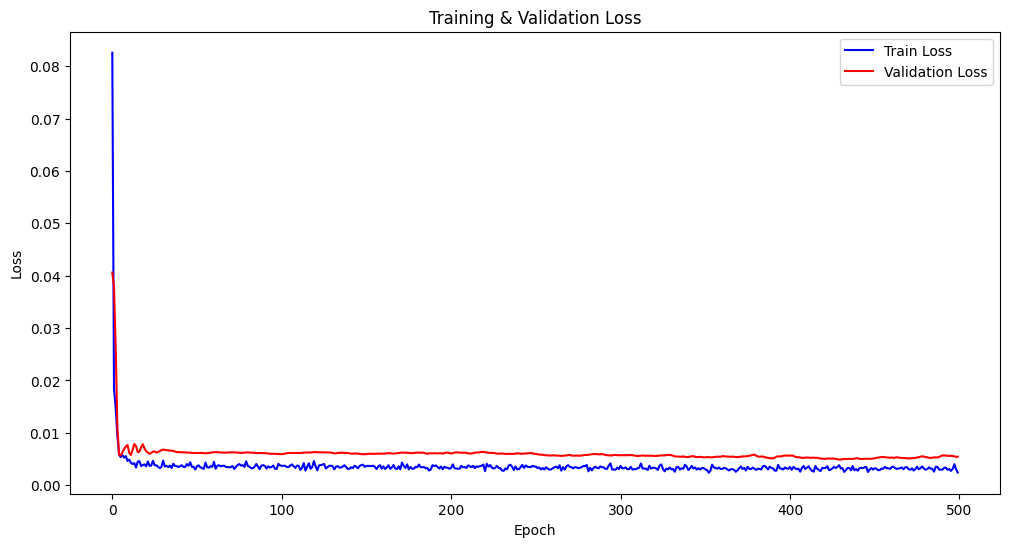

✅ Training history graph saved to /content/drive/MyDrive/stocks/AMZN/EnsembleModel/training_history.png
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0076 - mae: 0.0740
✅ Best Model Test Loss: 0.008596892468631268
✅ Best Model Test MAE: 0.07984421402215958
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


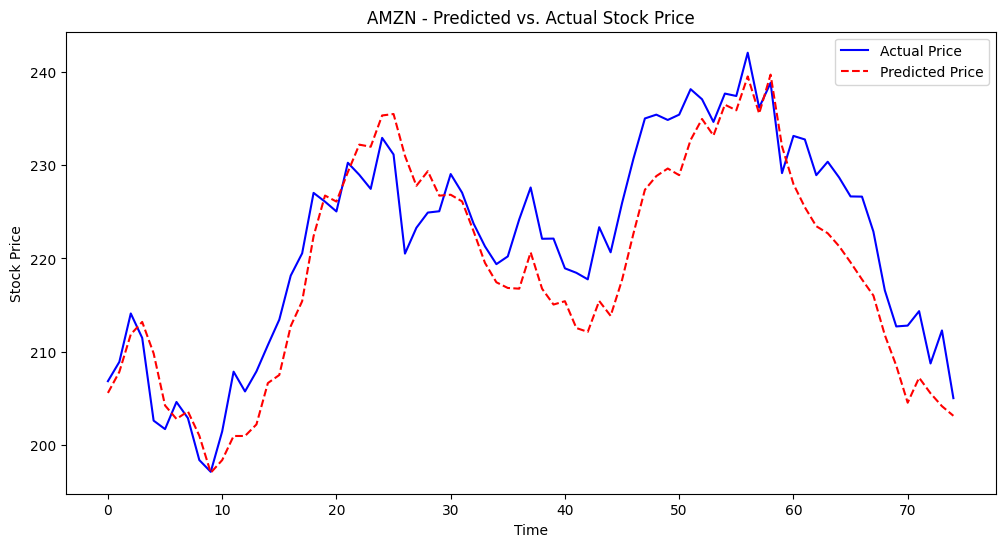

✅ Prediction vs. Actual plot saved to /content/drive/MyDrive/stocks/AMZN/EnsembleModel/pred_vs_actual.png

🎯 Ensemble Model Training & Prediction Complete for AMZN! 🚀


In [8]:
# %% [code]
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import json
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, SimpleRNN, LSTM, Dense, Dropout, Concatenate, Multiply, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# === Select Stock Folder ===
base_stocks_folder = '/content/drive/MyDrive/stocks'
stock_folders = [f for f in os.listdir(base_stocks_folder) if os.path.isdir(os.path.join(base_stocks_folder, f))]
if not stock_folders:
    print("No stock folders found in", base_stocks_folder)
    raise SystemExit

print("Available stock tickers:")
for i, stock in enumerate(stock_folders):
    print(f"{i + 1}. {stock}")

choice = int(input("Enter the number of the stock ticker to use for ensemble modeling: ")) - 1
selected_ticker = stock_folders[choice]
stock_path = os.path.join(base_stocks_folder, selected_ticker)
print(f"Selected ticker: {selected_ticker}")

# === Define Ensemble Save Folder (inside stock folder) ===
ensemble_folder = os.path.join(stock_path, "EnsembleModel")
os.makedirs(ensemble_folder, exist_ok=True)

# === Load Preprocessed Data from Stock Folder ===
X_train = np.load(os.path.join(stock_path, "X_train.npy"))
y_train = np.load(os.path.join(stock_path, "y_train.npy"))
X_val   = np.load(os.path.join(stock_path, "X_val.npy"))
y_val   = np.load(os.path.join(stock_path, "y_val.npy"))
X_test  = np.load(os.path.join(stock_path, "X_test.npy"))
y_test  = np.load(os.path.join(stock_path, "y_test.npy"))

# Load scaler for target variable (for inverse scaling later)
scaler_y = joblib.load(os.path.join(stock_path, "scaler_y.pkl"))

print(f"✅ Data Loaded: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"✅ X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"✅ X_test: {X_test.shape}, y_test: {y_test.shape}")

# === Reshape Data if Needed ===
# If X data is 2D (samples, features), reshape to (samples, timesteps, features)
if X_train.ndim == 2:
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val   = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
    X_test  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
input_shape = (X_train.shape[1], X_train.shape[2])
print(f"✅ Input shape for model: {input_shape}")

# === Hyperparameter Tuning / Load Best Hyperparameters ===
best_hps_path = os.path.join(ensemble_folder, "best_hyperparameters.json")
if os.path.exists(best_hps_path):
    print("✅ Loading best hyperparameters from file.")
    with open(best_hps_path, "r") as f:
        best_hps_dict = json.load(f)
    best_hps = kt.HyperParameters()
    for key, value in best_hps_dict.items():
        best_hps.Fixed(key, value)
else:
    print("🔍 No best hyperparameters found. Running hyperparameter tuning...")

    def build_ensemble_model(hp):
        inputs = Input(shape=input_shape)

        # Determine kernel size options based on timesteps
        if input_shape[0] == 1:
            kernel_size_options = [1]
            apply_pooling = False
        else:
            kernel_size_options = [3, 5, 7]
            apply_pooling = True

        # === CNN Branch ===
        cnn = Conv1D(filters=hp.Choice('cnn_filters', [64, 128, 256]),
                     kernel_size=hp.Choice('cnn_kernel_size', kernel_size_options),
                     activation='relu')(inputs)
        if apply_pooling:
            cnn = MaxPooling1D(pool_size=2)(cnn)
        cnn = Flatten()(cnn)
        cnn_weight = Dense(1, activation='sigmoid')(cnn)

        # === RNN Branch ===
        rnn = SimpleRNN(units=hp.Choice('rnn_units', [75, 100, 125]), return_sequences=True)(inputs)
        rnn = SimpleRNN(units=hp.Choice('rnn_units_2', [75, 100, 125]), return_sequences=True)(rnn)
        rnn = Attention()([rnn, rnn])
        rnn = Flatten()(rnn)
        rnn_weight = Dense(1, activation='sigmoid')(rnn)

        # === LSTM Branch ===
        lstm = LSTM(units=hp.Choice('lstm_units', [50, 75, 100]), return_sequences=True)(inputs)
        lstm = LSTM(units=hp.Choice('lstm_units_2', [50, 75, 100]), return_sequences=True)(lstm)
        lstm = Attention()([lstm, lstm])
        lstm = Flatten()(lstm)
        lstm_weight = Dense(1, activation='sigmoid')(lstm)

        # === Adaptive Weighted Fusion ===
        cnn_scaled = Multiply()([cnn, cnn_weight])
        rnn_scaled = Multiply()([rnn, rnn_weight])
        lstm_scaled = Multiply()([lstm, lstm_weight])

        merged = Concatenate()([cnn_scaled, rnn_scaled, lstm_scaled])
        merged = Dense(units=hp.Choice('dense_units', [50, 100, 150]), activation="relu")(merged)
        merged = Dropout(hp.Choice('dropout_rate', [0.1, 0.2, 0.3]))(merged)

        output = Dense(1)(merged)

        model = Model(inputs, output)
        model.compile(
            optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
            loss="mse",
            metrics=["mae"]
        )
        return model

    tuner = kt.RandomSearch(
        build_ensemble_model,
        objective="val_loss",
        max_trials=15,
        executions_per_trial=3,
        directory=os.path.join(ensemble_folder, "tuning"),
        project_name="stock_prediction_ensemble"
    )

    tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_hps_dict = {param: best_hps.get(param) for param in best_hps.values.keys()}
    with open(best_hps_path, "w") as f:
        json.dump(best_hps_dict, f)
    print(f"✅ Best hyperparameters saved to {best_hps_path}")

print("✅ Best hyperparameters:")
print(best_hps_dict)

# === Build and Train the Best Model ===
BATCH_SIZE = 32
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr],
    verbose=1
)

# === Save the Best Model and Training History ===
best_model_path = os.path.join(ensemble_folder, "best_ensemble_model.keras")
best_model.save(best_model_path)
print(f"✅ Best Ensemble Model saved to {best_model_path}")

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
history_plot_path = os.path.join(ensemble_folder, "training_history.png")
plt.savefig(history_plot_path)
plt.show()
print(f"✅ Training history graph saved to {history_plot_path}")

# === Evaluate the Model ===
loss, mae = best_model.evaluate(X_test, y_test)
print(f"✅ Best Model Test Loss: {loss}")
print(f"✅ Best Model Test MAE: {mae}")

# === Make Predictions and Inverse Scale ===
predictions = best_model.predict(X_test)
def inverse_transform_single_feature(scaler, data):
    data = np.array(data).reshape(-1, 1)
    return scaler.inverse_transform(data)
predictions_rescaled = inverse_transform_single_feature(scaler_y, predictions)
y_test_rescaled = inverse_transform_single_feature(scaler_y, y_test)

# === Plot Predicted vs Actual Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Price", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title(f"{selected_ticker} - Predicted vs. Actual Stock Price")
plt.legend()
pred_vs_actual_path = os.path.join(ensemble_folder, "pred_vs_actual.png")
plt.savefig(pred_vs_actual_path)
plt.show()
print(f"✅ Prediction vs. Actual plot saved to {pred_vs_actual_path}")

print(f"\n🎯 Ensemble Model Training & Prediction Complete for {selected_ticker}! 🚀")


In [9]:
# %% [code]
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming you already have predictions_rescaled and y_test_rescaled from your previous cell
# predictions_rescaled = ...
# y_test_rescaled = ...

# Calculate MAE and RMSE in the original stock price scale
mae_original = mean_absolute_error(y_test_rescaled, predictions_rescaled)
rmse_original = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))

print("=== Error Metrics in Original Scale ===")
print(f"MAE:  {mae_original:.4f} (units of actual stock price)")
print(f"RMSE: {rmse_original:.4f} (units of actual stock price)")


=== Error Metrics in Original Scale ===
MAE:  4.3623 (units of actual stock price)
RMSE: 5.0657 (units of actual stock price)
